In [5]:
import matplotlib.pyplot as plt
#matplotlib inline
import numpy as np
from qiskit.tools.visualization import plot_bloch_vector, plot_circuit_layout
from qiskit import BasicAer


from qiskit import execute
from qiskit.circuit import *


# the probability to be recovered
#probability = 0.125
#theta_p = 2*np.arcsin(np.sqrt(probability))

#print('theta_p : ', theta_p)



# set number of evaluation qubits
m = 3
M = 2**m


# construct first part of circuit
q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, name='c0')




def makeOracleA_00(circuit):
    circuit.x(q[1])
    circuit.x(q[2])
    circuit.ccx(q[2],q[1],q[0])
    circuit.x(q[1])
    circuit.x(q[2])
    
def makeOracleA_01(circuit):
    circuit.x(q[2])
    circuit.ccx(q[2],q[1],q[0])
    circuit.x(q[2])
    
def makeOracleA_10(circuit):
    circuit.x(q[1])
    circuit.ccx(q[2],q[1],q[0])
    circuit.x(q[1])

def makeOracleA_11(circuit):
    circuit.ccx(q[2],q[1],q[0])

    
def addH(circuit):
    circuit.h(q[1])
    circuit.h(q[2])
    
def addA(circuit):
    addH(circuit)
    makeOracleA_01(circuit)

def addAinv(circuit):
    makeOracleA_01(circuit)
    addH(circuit)

def addSx(circuit):
    circuit.z(q[0])
    
def addS0(circuit):
    circuit.x(q[0])
    circuit.h(q[0])
    circuit.x(q[1])
    circuit.x(q[2])
    circuit.ccx(q[2],q[1],q[0])
    circuit.x(q[2])
    circuit.x(q[1])
    circuit.h(q[0])
    circuit.x(q[0])
    
def addQ(circuit):
    addSx(circuit)
    #circuit.barrier(q)
    addAinv(circuit)
    #circuit.barrier(q)
    addS0(circuit)
    #circuit.barrier(q)
    addA(circuit)
    #circuit.barrier(q)
    
    
########################################################################################################################
## Circuit Start
########################################################################################################################

qc_0 = QuantumCircuit(q,c)

# A build
addA(qc_0)
#qc_0.barrier(q)


evaluation_schedule = [0] + [2**j for j in range(m)]
circuits = []
for k in evaluation_schedule:
    qc_k = qc_0.copy()

    if k != 0: # Q power
        for i in range(k):
            addQ(qc_k)

    # measurement
    qc_k.measure(q[0], c[0])

    circuits += [qc_k]


########################################################################################################################
## Circuit End
########################################################################################################################









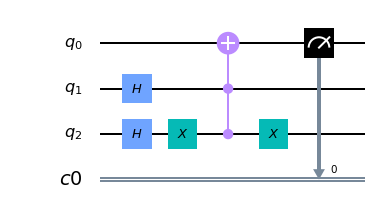

In [6]:
circuits[0].draw(output='mpl')

15


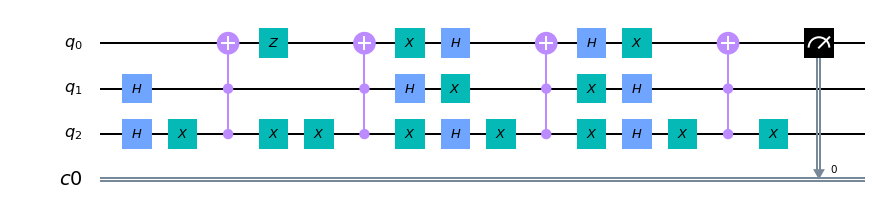

In [8]:
print(circuits[1].depth())
circuits[1].draw(output='mpl', plot_barriers=True, fold=50)


26


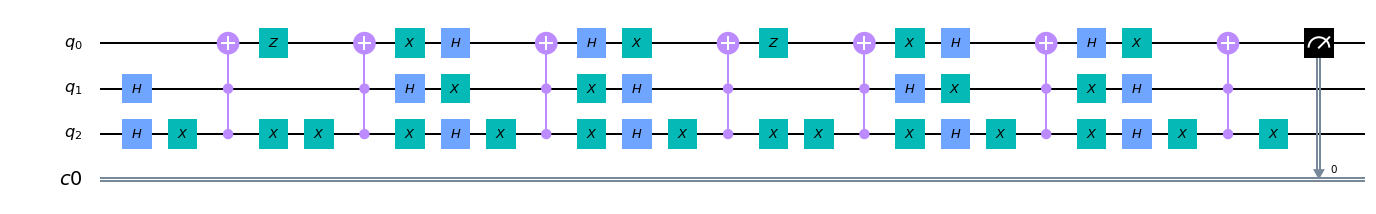

In [9]:
print(circuits[2].depth())
circuits[2].draw(output='mpl', fold=27)

48


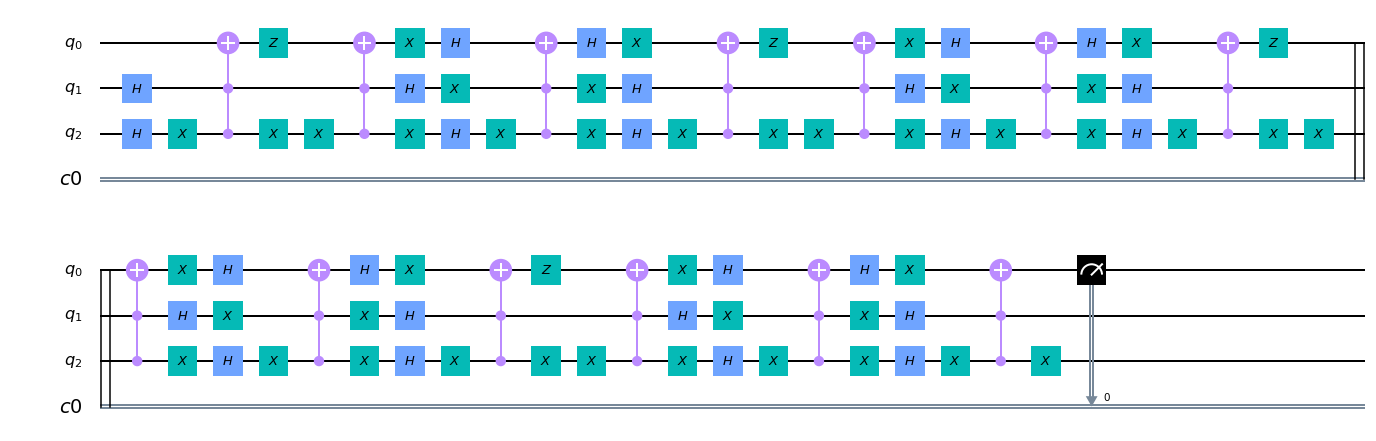

In [10]:
print(circuits[3].depth())
circuits[3].draw(output='mpl', fold=27)

In [12]:

backend = BasicAer.get_backend('qasm_simulator')



results = []
#print(circuits)

jobs = [execute(circuits[k], backend, shots=1024) for k in range(len(circuits))]
results = [jobs[k].result() for k in range(len(jobs))]

    

counts = [results[k].get_counts(circuits[k]) for k in range(len(circuits))]





{'1': 258, '0': 766}


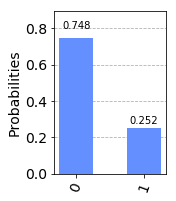

In [13]:
from qiskit.visualization import plot_histogram

print(counts[0])
plot_histogram(counts[0], figsize=(2, 3))


{'1': 1024}


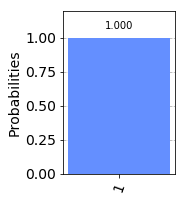

In [14]:
print(counts[1])
plot_histogram(counts[1], figsize=(2, 3))


{'1': 258, '0': 766}


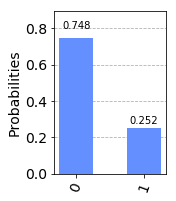

In [15]:
print(counts[2])
plot_histogram(counts[2], figsize=(2, 3))

{'1': 1024}


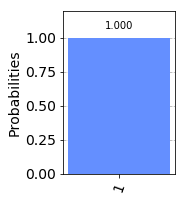

In [16]:
print(counts[3])
plot_histogram(counts[3], figsize=(2, 3))

In [17]:


########################################################################################################################
## MLE Start
########################################################################################################################


from scipy.optimize import brute

likelihood_evals = np.maximum(10000, int(np.pi / 2 * 1000 * 2 ** m))

eps = 1e-15  # to avoid invalid value in log
search_range = [0 + eps, np.pi / 2 - eps]

def loglikelihood(theta):
    # logL contains the first `it` terms of the full loglikelihood
    logL = 0
    for i, k in enumerate(evaluation_schedule):
        logL += np.log(np.sin((2 * k + 1) * theta) ** 2) * one_hits[i]
        logL += np.log(np.cos((2 * k + 1) * theta) ** 2) * (all_hits[i] - one_hits[i])
    return -logL


#print(counts[0].values())

one_hits = []  # h_k: how often 1 has been measured, for a power Q^(m_k)
all_hits = []  # N_k: how often has been measured at a power Q^(m_k)

for c in counts:
    one_hits += [c.get('1', 0)]  # return 0 if no key '1' found
    all_hits += [sum(c.values())]
            
est_theta = brute(loglikelihood, [search_range], Ns=likelihood_evals)[0]
est_prob = np.sin(est_theta)**2

print(one_hits)
print(all_hits)
print('Estimated theta : ', est_theta)
print('Estimated probability : ', est_prob)


########################################################################################################################
## MLE End
########################################################################################################################



[258, 1024, 258, 1024]
[1024, 1024, 1024, 1024]
Estimated theta :  0.5234832071664244
Estimated probability :  0.24989992148104354


In [35]:
from qiskit import IBMQ
from qiskit.compiler.transpile import *

#IBMQ.enable_account('YOUR_TOKEN')
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')



#backend = provider.get_backend('ibmq_vigo')
backend = provider.get_backend('ibmqx2')



trans_circuit = [transpile(circuits[k], backend, optimization_level=3) for k in range(len(circuits))]
#cir_trans_l3 = transpile(circuits[1], backend, optimization_level=3)


Depth :  12


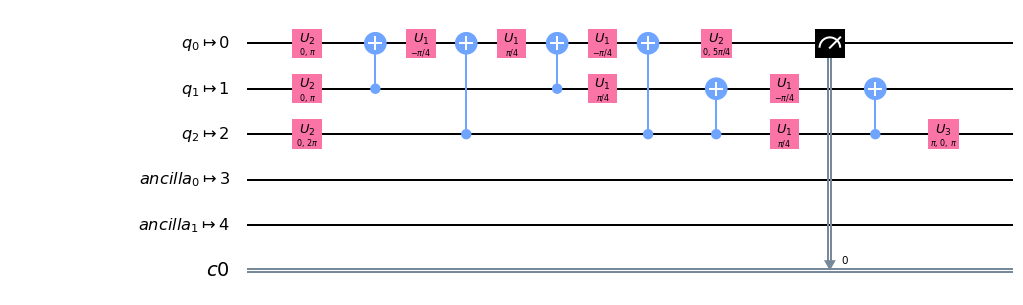

In [36]:
print('Depth : ', trans_circuit[0].depth())
trans_circuit[0].draw(output='mpl', fold=27)

Depth :  44


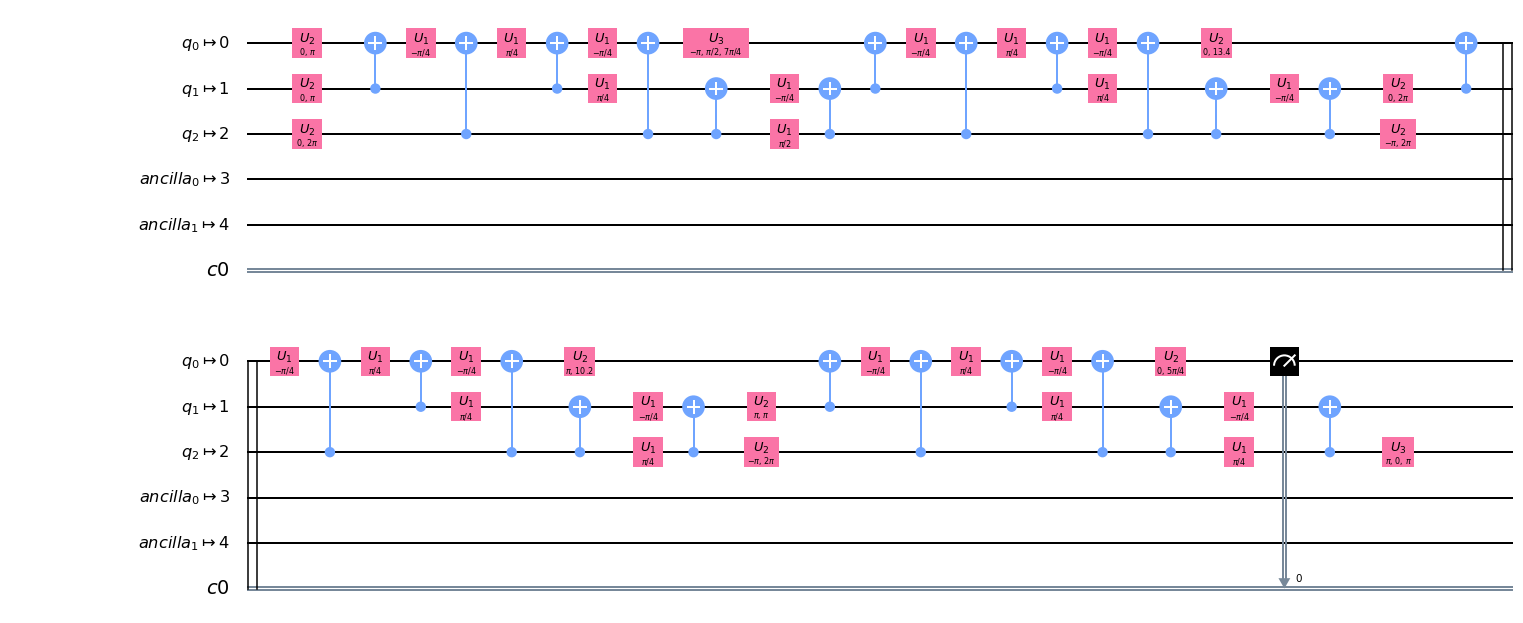

In [37]:
print('Depth : ', trans_circuit[1].depth())
trans_circuit[1].draw(output='mpl', fold=27)

Depth :  76


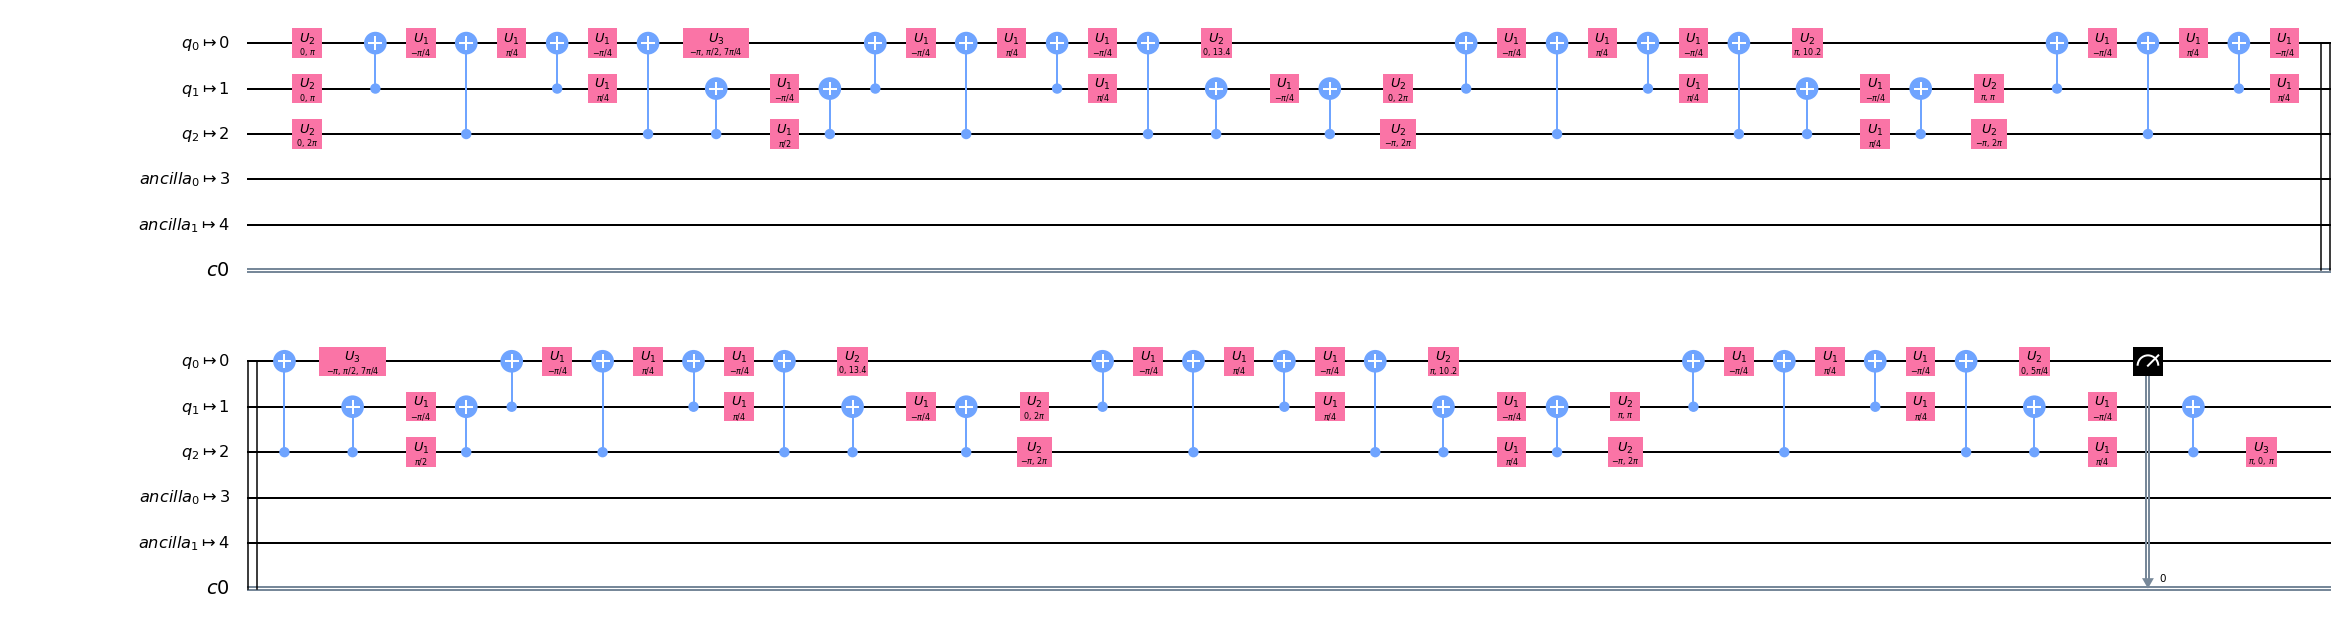

In [38]:
print('Depth : ', trans_circuit[2].depth())
trans_circuit[2].draw(output='mpl', fold=45)

Depth :  140


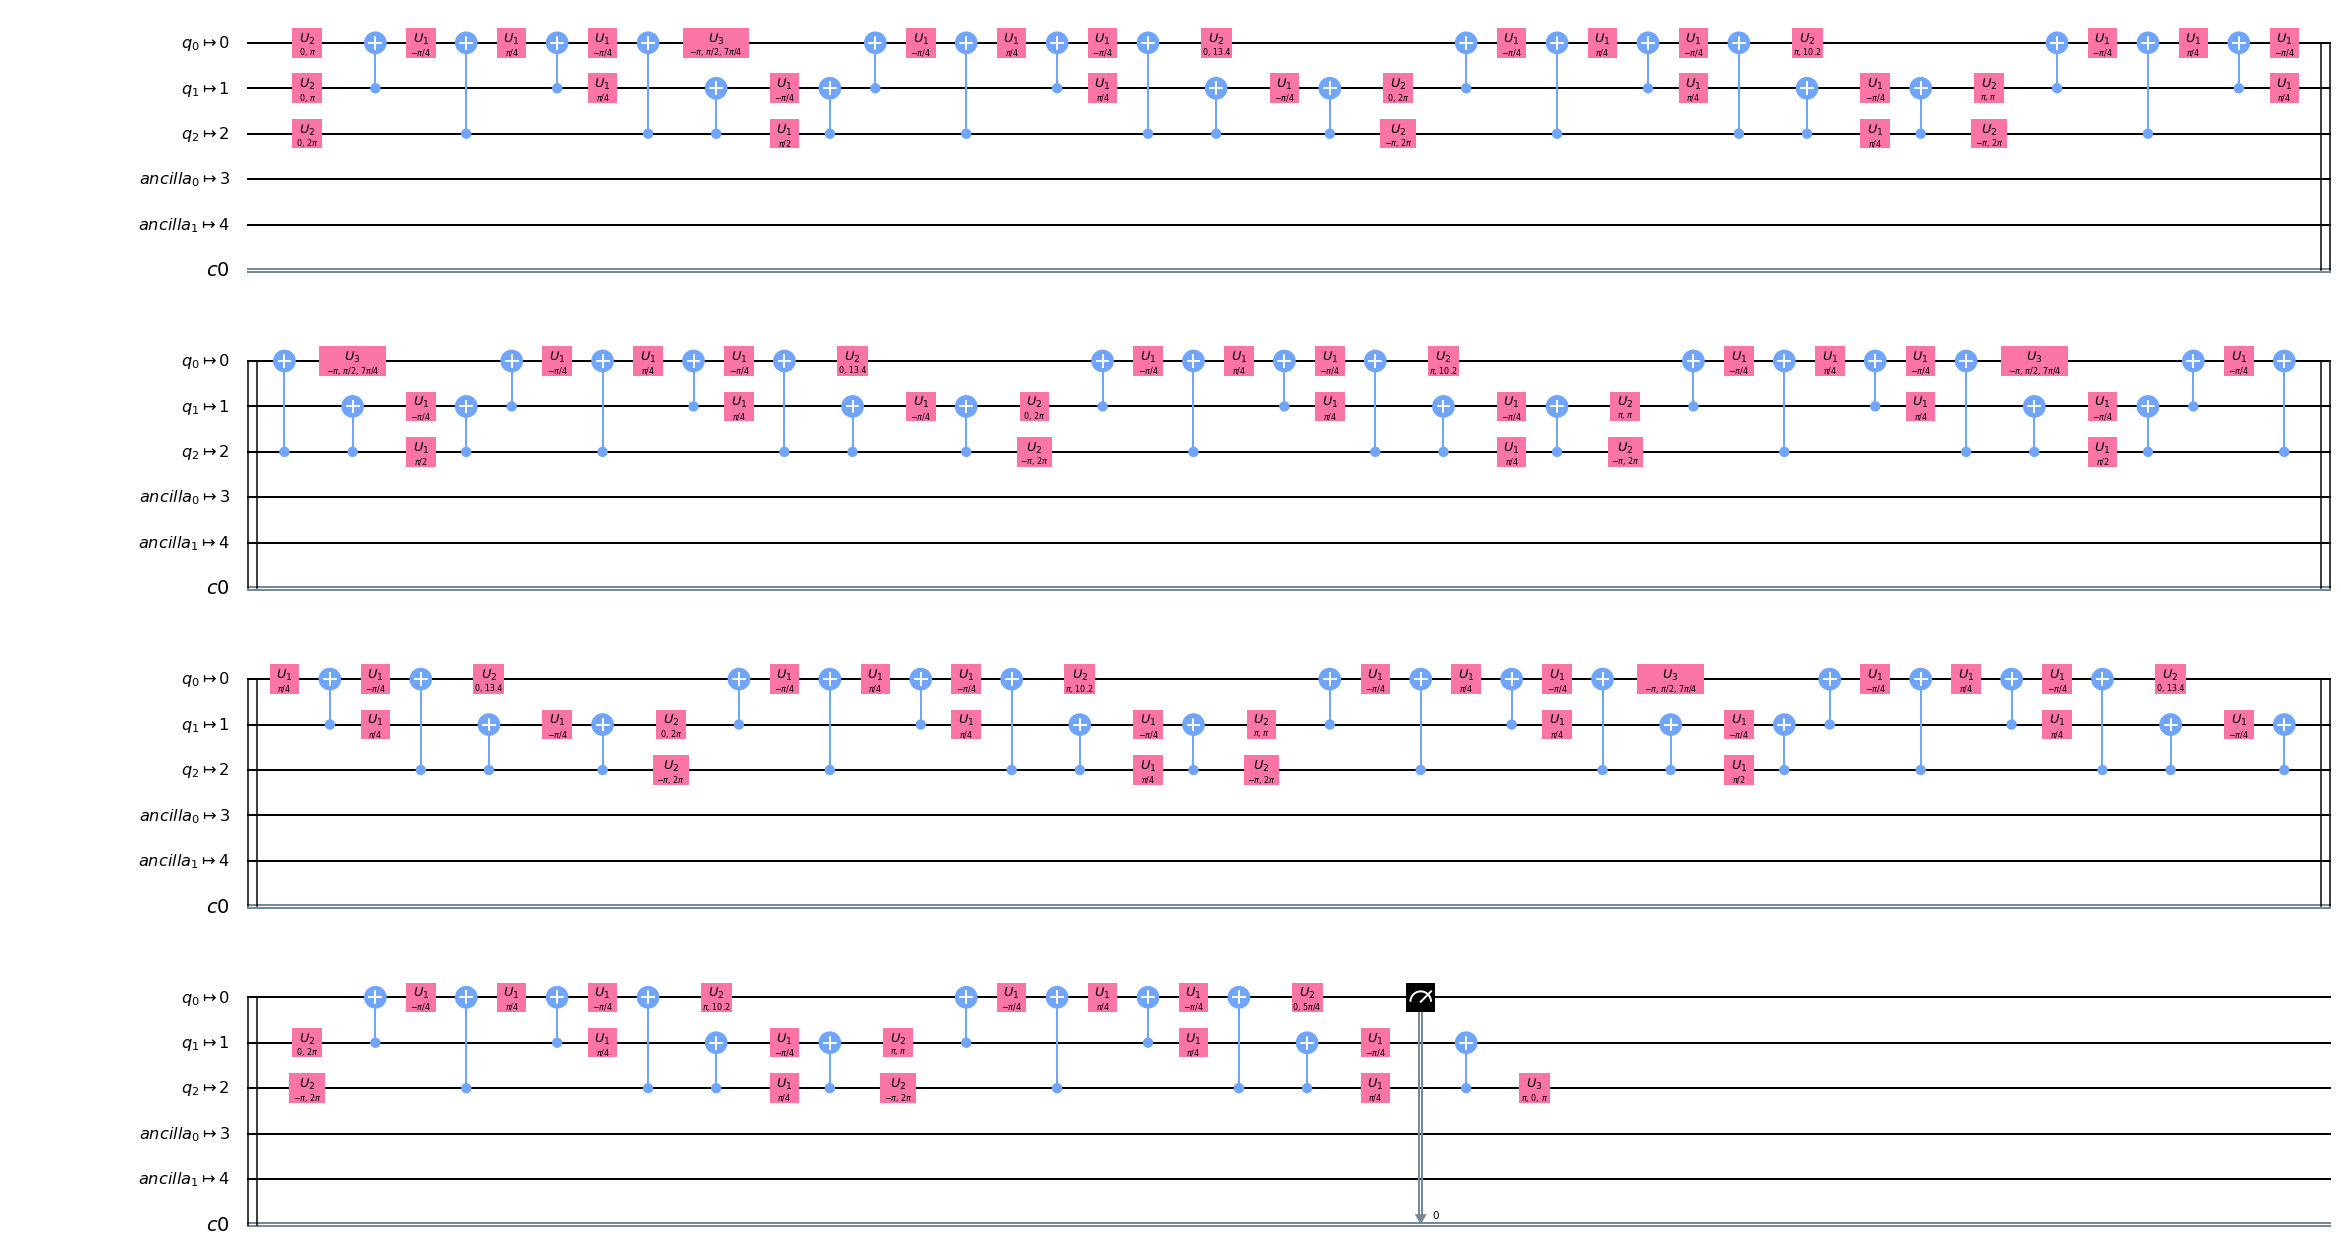

In [39]:
print('Depth : ', trans_circuit[3].depth())
trans_circuit[3].draw(output='mpl', fold=45)

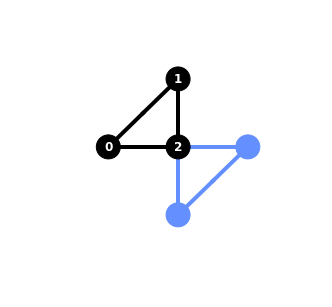

In [40]:
plot_circuit_layout(trans_circuit[3], backend)


In [102]:
#from qiskit.providers.ibmq.managed import IBMQJobManager
#job_manager = IBMQJobManager()
#jobs_dev = job_manager.run(trans_circuit, backend)

jobs_dev = [execute(trans_circuit[k], backend, shots=1024) for k in range(len(trans_circuit))]
#jobs_dev = []

#job_dev = execute(trans_circuit[0], backend, shots=1024)




In [103]:
len(jobs_dev)

4

In [105]:
results_dev = [jobs_dev[k].result() for k in range(len(jobs))]
counts_dev = [results_dev[k].get_counts(trans_circuit[k]) for k in range(len(trans_circuit))]


{'0': 556, '1': 468}


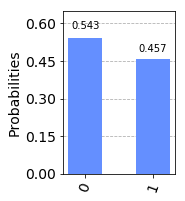

In [159]:
print(counts_dev[0])
plot_histogram(counts_dev[0], figsize=(2, 3))

{'0': 286, '1': 738}


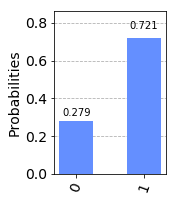

In [160]:
print(counts_dev[1])
plot_histogram(counts_dev[1], figsize=(2, 3))

{'0': 429, '1': 595}


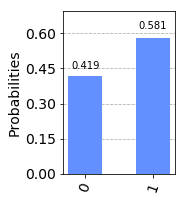

In [161]:
print(counts_dev[2])
plot_histogram(counts_dev[2], figsize=(2, 3))

{'0': 357, '1': 667}


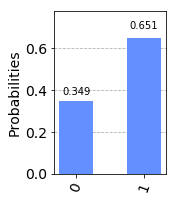

In [162]:
print(counts_dev[3])
plot_histogram(counts_dev[3], figsize=(2, 3))

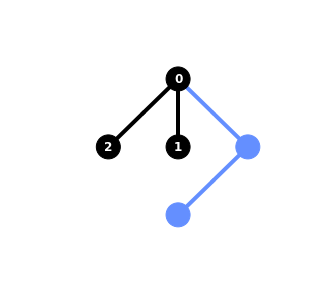

In [213]:
backend_vigo = provider.get_backend('ibmq_vigo')
#backend = provider.get_backend('ibmq_johannesburg')


trans_circuit_vigo = transpile(circuits[1], backend_vigo, optimization_level=3)
plot_circuit_layout(trans_circuit_vigo, backend_vigo)




In [34]:


########################################################################################################################
## MLE Start
########################################################################################################################



import numpy as np
from scipy.optimize import brute


def MaximumLikelihoodEstmator(circuit_length, ones, zeros):

    grid = 20000
    epsilon = 1/grid  
    domain = [0.0 + epsilon, np.pi/2 - epsilon] # to avoid zero

    def logL(theta):
        fval = 0
        for i in range(circuit_length):
            if i==0:
                fval += 2 * ones[i] * np.log( np.absolute(np.sin(theta)) ) 
                fval += 2 * zeros[i] * np.log( np.absolute(np.cos(theta)) )
            else:
                fval += 2 * ones[i] * np.log( np.absolute(np.sin((2 * (2**(i-1)) + 1) * theta)) )
                fval += 2 * zeros[i] * np.log( np.absolute(np.cos((2 * (2**(i-1)) + 1) * theta)) )
        return -fval # to compute maximum

    return brute(logL, [domain], Ns=grid)[0]

    

ones_sim = [248, 1024, 249, 1024]
zeros_sim = [776, 0, 775, 0]

ones_ibmqx2 = [468, 738, 595, 667]
zeros_ibmqx2= [556, 286, 429, 357]

ones_vigo = [274, 712, 401, 589]
zeros_vigo = [750, 312, 623, 435]


est_theta_sim = MaximumLikelihoodEstmator(4, ones_sim, zeros_sim)
est_prob_sim = np.sin(est_theta_sim)**2

print('Estimated theta Simulator : ', est_theta_sim)
print('Estimated probability Simulator : ', est_prob_sim)

est_theta_ibmqx2 = MaximumLikelihoodEstmator(4, ones_ibmqx2, zeros_ibmqx2)
est_prob_ibmqx2 = np.sin(est_theta_ibmqx2)**2

print('Estimated theta IBMQX2 : ', est_theta_ibmqx2)
print('Estimated probability IBMQX2 : ', est_prob_ibmqx2)

est_theta_vigo = MaximumLikelihoodEstmator(4, ones_vigo, zeros_vigo)
est_prob_vigo = np.sin(est_theta_vigo)**2

print('Estimated theta IBM Q VIGO : ', est_theta_vigo)
print('Estimated probability IBM Q VIGO : ', est_prob_vigo)




########################################################################################################################
## MLE End
########################################################################################################################







Estimated theta Simulator :  0.5240093173608057
Estimated probability Simulator :  0.2503556238279605
Estimated theta IBMQX2 :  0.7946652658528821
Estimated probability IBMQX2 :  0.5092665718970579
Estimated theta IBM Q VIGO :  0.7795470270233185
Estimated probability IBM Q VIGO :  0.49414899717050004
